In [1]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt

from data import pipeline
from data.window import SlidingWindow

# Data preparation

In [2]:
X_train, Y_train, X_test, Y_test = pipeline.load("LSTM") # load / buildAndSave / build

Loading LSTM dataset
Done!


In [3]:
print(X_train.shape)
print(Y_train.shape)

(1027718, 4, 8)
(1027718, 1)


In [4]:
from sklearn.preprocessing import StandardScaler

X_train = X_train.reshape(-1, 32)
X_test = X_test.reshape(-1, 32)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
Y_train = sc_y.fit_transform(Y_train.reshape(-1, 1))
print(Y_train.shape)

(1027718, 1)


In [5]:
X_train = X_train.reshape(-1, 4, 8)
X_test = X_test.reshape(-1, 4, 8)

# Training

In [6]:
batch, window, features = X_train.shape

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

# Function to create model, required for KerasClassifier
def create_model(units):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(window, features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# create model
units = KerasRegressor(model=create_model, epochs=10, batch_size=10, verbose=1)

# define the grid search parameters
neurons = [65, 70, 75, 80, 85, 90]
param_grid = dict(model__units=units)

grid = RandomizedSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

ModuleNotFoundError: No module named 'scikeras'

In [51]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(86, activation='relu', input_shape=(window, features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [52]:
model.fit(X_train, Y_train)

32117/32117 [==============================] - 82s 3ms/step - loss: 0.0630


In [53]:
from sklearn.metrics import mean_squared_error

print('Train MSE : %.3f'%mean_squared_error(Y_train, model.predict(X_train)))

32117/32117 [==============================] - 42s 1ms/step
Train MSE : 0.048


# Evaluation

In [54]:
X_test = X_test[:1000]

In [55]:
sw = SlidingWindow(X_test)

In [56]:
pred = model.predict(sw.values.reshape(-1, 4, 8), verbose=2)
Y_preds = [pred]

1/1 - 0s - 14ms/epoch - 14ms/step


In [ ]:
last_progression = 0
print(0, '%')
while sw.next(pred): # iterator: t-1
    pred = model.predict(sw.values.reshape(-1, 4, 8), verbose=0) # iterator: t
    Y_preds.append(pred)
        
    progression = (sw.it+1) / len(X_test) * 100
    if progression - last_progression > 1 and not int(progression) % 10:
        print(int(progression), '%')
        last_progression = progression

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %


In [ ]:
Y_preds = np.array(Y_preds)

In [ ]:
Y_preds = sc_y.inverse_transform(Y_preds.reshape(1, -1))
Y_preds = Y_preds.reshape(-1)

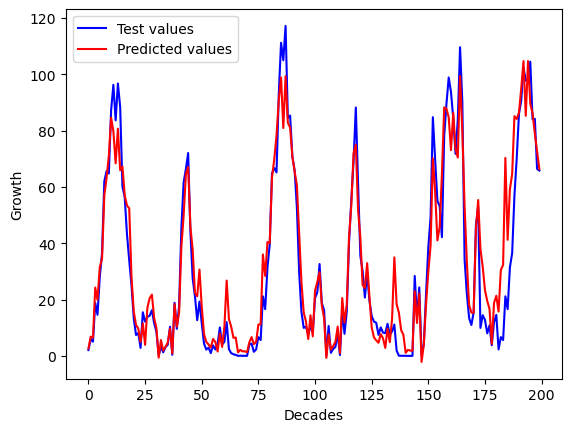

In [ ]:
Y_preds = Y_preds.reshape(-1)
plt.plot(np.arange(len(Y_preds[:200])), Y_test[:200], color="blue", label= "Test values")
plt.plot(np.arange(len(Y_preds[:200])), Y_preds[:200], color="red", label= "Predicted values")
plt.xlabel("Decades")
plt.ylabel("Growth")
plt.legend()
plt.show()

In [ ]:
print('Test MSE  : %.3f'%mean_squared_error(Y_test[:1000], Y_preds))

Test MSE  : 78.228
